# Red GAN

### Importar librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [ ]:
(X_entreno, y_entreno), (X_prueba, y_prueba) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


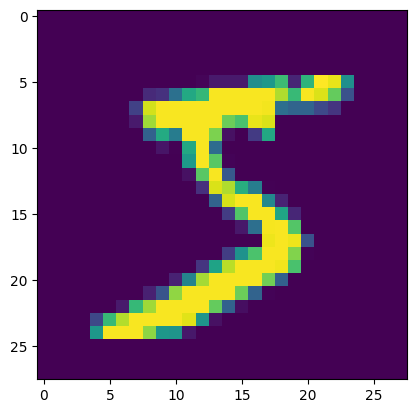

In [ ]:
plt.imshow(X_entreno[0])

### Normalizar datos

In [ ]:
X_entreno = X_entreno/255

In [ ]:
X_entreno.shape

(60000, 28, 28)

In [ ]:
X_entreno = X_entreno.reshape(-1, 28, 28, 1) * 2. - 1.

### Creación del generador

In [5]:
np.random.seed(42)
tf.random.set_seed(42)
tamanio_codificacion = 100

In [ ]:
generador = Sequential()
generador.add(Dense(7 * 7 * 128,
                    input_shape = [tamanio_codificacion]))
generador.add(Reshape([7, 7, 128]))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(64,
                              kernel_size = 5,
                              strides = 2,
                              padding = "same",
                              activation = "relu"))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(1,
                              kernel_size = 5,
                              strides = 2,
                              padding = "same",
                              activation = "tanh"))



### Creación del discriminador

In [ ]:
discriminador = Sequential()
discriminador.add(Conv2D(64,
                         kernel_size = 5,
                         strides = 2,
                         padding = "same",
                         activation = LeakyReLU(0.3),
                         input_shape = [28, 28, 1]))
discriminador.add(Dropout(0.5))
discriminador.add(Conv2D(128,
                         kernel_size = 5,
                         strides = 2,
                         padding = "same",
                         activation = LeakyReLU(0.3)))
discriminador.add(Dropout(0.5))
discriminador.add(Flatten())
discriminador.add(Dense(1,
                        activation = "sigmoid"))

### Red GAN

In [ ]:
GAN = Sequential([generador, discriminador])

In [ ]:
discriminador.compile(loss="binary_crossentropy", optimizer="adam")
discriminador.trainable = False

In [ ]:
GAN.compile(loss = "binary_crossentropy",
            optimizer = "adam")

### Entrenamiento

In [ ]:
mis_datos = X_entreno
tamanio_tanda = 32
epocas = 20
datos = tf.data.Dataset.from_tensor_slices(mis_datos).shuffle(buffer_size = 1000)
datos = datos.batch(tamanio_tanda,
                    drop_remainder = True).prefetch(1)

generador, discriminador = GAN.layers

In [ ]:
for epoca in range(epocas):
    print(f"Voy por la época {epoca + 1}")
    i = 0
    # Para cada tanda en el conjunto de datos
    for X_tanda in datos:
        i = i + 1
        if i % 25 == 0:
            print(f"\tVoy por la tanda número {i} de {len(mis_datos) // tamanio_tanda}")

        ##############################################
        ## Fase 1 - Entrenamiento del DISCRIMINADOR ##
        ##############################################

        # Crear Ruido
        ruido = tf.random.normal(shape = [tamanio_tanda,
                                          tamanio_codificacion])

        # Generar imágenes falsas (números) basadas sólo en una entrada de ruido
        # Notar que el Generador nunca vé imágenes reales (solo ruido)
        imagenes_gen = generador(ruido)

        # Concatenar las Imágenes Generadas con las Verdaderas
        # Para poder utilizar tf.concat, los tipos de los datos deben
        #    coincidir!
        X_falso_vs_real = tf.concat([imagenes_gen,
                                     tf.dtypes.cast(X_tanda,
                                                    tf.float32)],
                                    axis = 0)

        # Las metas se fijan en cero (0) para imágenes falsas
        #     y uno (1) para imágenes reales
        y1 = tf.constant([[0.]] * tamanio_tanda + [[1.]] * tamanio_tanda)

        # La siguiente instrucción obvia una advertencia de Keras
        discriminador.trainable = True

        # Entrenar al discriminador con esta tanda
        discriminador.train_on_batch(X_falso_vs_real, y1)


        ##########################################
        ## Fase 2 - Entrenamiento del GENERADOR ##
        ##########################################

        # Crear algo de ruido
        ruido = tf.random.normal(shape=[tamanio_tanda,
                                        tamanio_codificacion])

        # Se quiere que el discriminador crea
        #   que las imágenes falas son reales
        y2 = tf.constant([[1.]] * tamanio_tanda)

        # Evitar una advertencia
        discriminador.trainable = False

        GAN.train_on_batch(ruido, y2)

print("Entrenamiento Completado")

Voy por la época 1
	Voy por la tanda número 25 de 1875
	Voy por la tanda número 50 de 1875
	Voy por la tanda número 75 de 1875
	Voy por la tanda número 100 de 1875
	Voy por la tanda número 125 de 1875
	Voy por la tanda número 150 de 1875
	Voy por la tanda número 175 de 1875
	Voy por la tanda número 200 de 1875
	Voy por la tanda número 225 de 1875
	Voy por la tanda número 250 de 1875
	Voy por la tanda número 275 de 1875
	Voy por la tanda número 300 de 1875
	Voy por la tanda número 325 de 1875
	Voy por la tanda número 350 de 1875
	Voy por la tanda número 375 de 1875
	Voy por la tanda número 400 de 1875
	Voy por la tanda número 425 de 1875
	Voy por la tanda número 450 de 1875
	Voy por la tanda número 475 de 1875
	Voy por la tanda número 500 de 1875
	Voy por la tanda número 525 de 1875
	Voy por la tanda número 550 de 1875
	Voy por la tanda número 575 de 1875
	Voy por la tanda número 600 de 1875
	Voy por la tanda número 625 de 1875
	Voy por la tanda número 650 de 1875
	Voy por la tanda núme

### Generar imágenes

In [6]:
ruido = tf.random.normal(shape = [10, tamanio_codificacion])

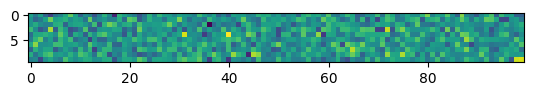

In [8]:
plt.imshow(ruido)

In [ ]:
imagenes = generador(ruido)

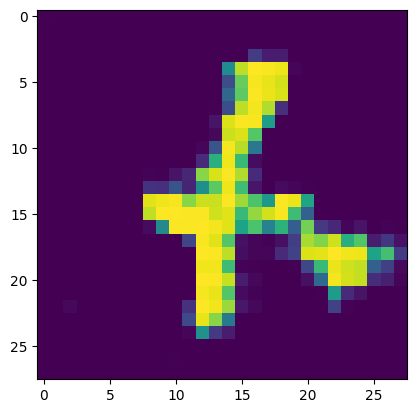

In [ ]:
plt.imshow(imagenes[0])

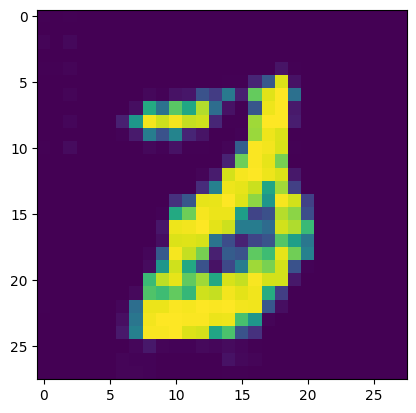

In [ ]:
plt.imshow(imagenes[3])

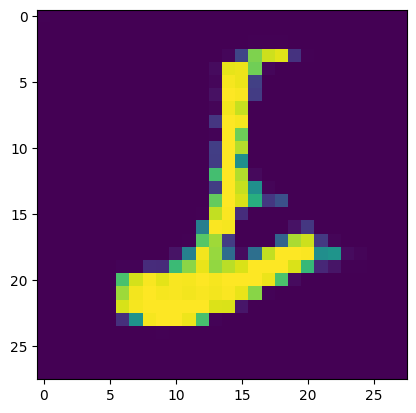

In [ ]:
plt.imshow(imagenes[6])

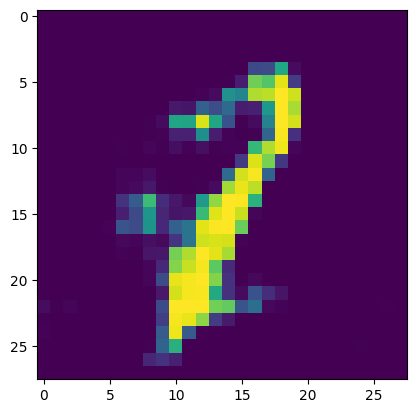

In [ ]:
plt.imshow(imagenes[9])